In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler, GPSampler
from optuna import visualization

In [2]:
df = pd.read_csv("../data/Suzuki-Miyaura/aap9112_complete_grid.csv")

In [3]:
# リストの作成
reactant_1_name_list = df['Reactant_1_Name'].unique().tolist()
reactant_2_name_list = df['Reactant_2_Name'].unique().tolist()
catalyst_1_short_hand_list = df['Catalyst_1_Short_Hand'].unique().tolist()
ligand_short_hand_list = df['Ligand_Short_Hand'].unique().tolist()
reagent_1_short_hand_list = df['Reagent_1_Short_Hand'].unique().tolist()
solvent_1_short_hand_list = df['Solvent_1_Short_Hand'].unique().tolist()

print(f"  Reactant_1_Name: {len(reactant_1_name_list)}")
print(f"  Reactant_2_Name: {len(reactant_2_name_list)}")
print(f"  Catalyst_1_Short_Hand: {len(catalyst_1_short_hand_list)}")
print(f"  Ligand_Short_Hand: {len(ligand_short_hand_list)}")
print(f"  Reagent_1_Short_Hand: {len(reagent_1_short_hand_list)}")
print(f"  Solvent_1_Short_Hand: {len(solvent_1_short_hand_list)}")
print(f"  総組み合わせ数: {len(reactant_1_name_list) * len(reactant_2_name_list) * len(catalyst_1_short_hand_list) * len(ligand_short_hand_list) * len(reagent_1_short_hand_list) * len(solvent_1_short_hand_list):,}")

# 辞書の作成
keys = list(zip(df['Reactant_1_Name'], df['Reactant_2_Name'], 
                df['Catalyst_1_Short_Hand'], df['Ligand_Short_Hand'], 
                df['Reagent_1_Short_Hand'], df['Solvent_1_Short_Hand']))
yield_dict = dict(zip(keys, df['Product_Yield_PCT_Area_UV']))

  Reactant_1_Name: 4
  Reactant_2_Name: 3
  Catalyst_1_Short_Hand: 1
  Ligand_Short_Hand: 11
  Reagent_1_Short_Hand: 7
  Solvent_1_Short_Hand: 4
  総組み合わせ数: 3,696


In [4]:
#目的関数の定義
def objective(trial):
    """
    反応収率を最適化する目的関数
    """
    # 各反応成分のカテゴリパラメータをサンプリング
    reactant_1_name = trial.suggest_categorical('reactant_1_name', reactant_1_name_list)
    reactant_2_name = trial.suggest_categorical('reactant_2_name', reactant_2_name_list)
    catalyst_1_short_hand = trial.suggest_categorical('catalyst_1_short_hand', catalyst_1_short_hand_list)
    ligand_short_hand = trial.suggest_categorical('ligand_short_hand', ligand_short_hand_list)
    reagent_1_short_hand = trial.suggest_categorical('reagent_1_short_hand', reagent_1_short_hand_list)
    solvent_1_short_hand = trial.suggest_categorical('solvent_1_short_hand', solvent_1_short_hand_list)
    
    # 検索キーの作成
    key = (reactant_1_name, reactant_2_name, catalyst_1_short_hand,
            ligand_short_hand, reagent_1_short_hand, solvent_1_short_hand)
    
    # 実験データから収率を取得
    if key in yield_dict:
        yield_value = yield_dict[key]
    else:
        # 未知の組み合わせには0を返す
        yield_value = 0.0
    
    # 後の分析用に追加情報を保存
    trial.set_user_attr('reactant_1_name', reactant_1_name)
    trial.set_user_attr('reactant_2_name', reactant_2_name)
    trial.set_user_attr('catalyst_1_short_hand', catalyst_1_short_hand)
    trial.set_user_attr('ligand_short_hand', ligand_short_hand)
    trial.set_user_attr('reagent_1_short_hand', reagent_1_short_hand)
    trial.set_user_attr('solvent_1_short_hand', solvent_1_short_hand)
    trial.set_user_attr('yield', yield_value)
    
    return yield_value

## TPE Sampler

In [5]:
def run_tpe_optimization(n_trials=100, seed=42, db_path="../runs/optuna_tpe_100trials_SM/optuna_tpe_100trials_SM.db"):
    """
    反応収率最大化のためのTPE最適化を実行

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    
    # TPEサンプラーを設定
    sampler = TPESampler(
        n_startup_trials=10,    # 初期探索用のランダムサンプリング
        n_ei_candidates=24,     # 期待改善候補数
        seed=seed               # 再現可能な結果を保証
    )
    
    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction='maximize',                    # 収率を最大化
        sampler=sampler,                        # TPEサンプラーを使用
        study_name='tpe_yield_optimization_SM',
        storage=f"sqlite:///{db_path}",         # 永続化ストレージ
    )
    
    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study

In [6]:
study = run_tpe_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:19:48,318] A new study created in RDB with name: tpe_yield_optimization_SM
Best trial: 0. Best value: 39.9838:   1%|          | 1/100 [00:00<00:24,  4.00it/s]

[I 2025-09-25 06:19:48,565] Trial 0 finished with value: 39.9838434308955 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 0 with value: 39.9838434308955.


Best trial: 0. Best value: 39.9838:   2%|▏         | 2/100 [00:00<00:23,  4.18it/s]

[I 2025-09-25 06:19:48,793] Trial 1 finished with value: 36.7830173819224 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'THF'}. Best is trial 0 with value: 39.9838434308955.


Best trial: 2. Best value: 55.1293:   3%|▎         | 3/100 [00:00<00:27,  3.50it/s]

[I 2025-09-25 06:19:49,135] Trial 2 finished with value: 55.1292974217532 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 2 with value: 55.1292974217532.


Best trial: 2. Best value: 55.1293:   4%|▍         | 4/100 [00:01<00:27,  3.43it/s]

[I 2025-09-25 06:19:49,437] Trial 3 finished with value: 0.0 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 2 with value: 55.1292974217532.


Best trial: 2. Best value: 55.1293:   5%|▌         | 5/100 [00:01<00:28,  3.35it/s]

[I 2025-09-25 06:19:49,747] Trial 4 finished with value: 30.2905859938007 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'THF'}. Best is trial 2 with value: 55.1292974217532.


Best trial: 5. Best value: 68.3272:   6%|▌         | 6/100 [00:01<00:29,  3.22it/s]

[I 2025-09-25 06:19:50,082] Trial 5 finished with value: 68.3271978265171 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 5 with value: 68.3271978265171.


Best trial: 6. Best value: 96.6033:   7%|▋         | 7/100 [00:02<00:28,  3.25it/s]

[I 2025-09-25 06:19:50,379] Trial 6 finished with value: 96.6033244317233 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:   8%|▊         | 8/100 [00:02<00:28,  3.22it/s]

[I 2025-09-25 06:19:50,697] Trial 7 finished with value: 15.410461843799 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:   9%|▉         | 9/100 [00:02<00:28,  3.17it/s]

[I 2025-09-25 06:19:51,023] Trial 8 finished with value: 15.7975197629559 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  10%|█         | 10/100 [00:03<00:28,  3.19it/s]

[I 2025-09-25 06:19:51,333] Trial 9 finished with value: 25.151362606933 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  11%|█         | 11/100 [00:03<00:28,  3.16it/s]

[I 2025-09-25 06:19:51,658] Trial 10 finished with value: 19.4799693510119 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  12%|█▏        | 12/100 [00:03<00:27,  3.17it/s]

[I 2025-09-25 06:19:51,970] Trial 11 finished with value: 94.8302362359257 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  13%|█▎        | 13/100 [00:03<00:28,  3.10it/s]

[I 2025-09-25 06:19:52,311] Trial 12 finished with value: 91.2890335559942 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  14%|█▍        | 14/100 [00:04<00:27,  3.10it/s]

[I 2025-09-25 06:19:52,635] Trial 13 finished with value: 91.7709557266964 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  15%|█▌        | 15/100 [00:04<00:27,  3.05it/s]

[I 2025-09-25 06:19:52,974] Trial 14 finished with value: 15.5264191505195 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  16%|█▌        | 16/100 [00:04<00:27,  3.05it/s]

[I 2025-09-25 06:19:53,302] Trial 15 finished with value: 87.6038615592912 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  17%|█▋        | 17/100 [00:05<00:26,  3.11it/s]

[I 2025-09-25 06:19:53,608] Trial 16 finished with value: 95.5822292817741 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  18%|█▊        | 18/100 [00:05<00:27,  2.99it/s]

[I 2025-09-25 06:19:53,970] Trial 17 finished with value: 54.8505815180369 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  19%|█▉        | 19/100 [00:05<00:26,  3.08it/s]

[I 2025-09-25 06:19:54,273] Trial 18 finished with value: 51.1318889283443 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  20%|██        | 20/100 [00:06<00:26,  3.07it/s]

[I 2025-09-25 06:19:54,602] Trial 19 finished with value: 21.2642371990921 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  21%|██        | 21/100 [00:06<00:25,  3.08it/s]

[I 2025-09-25 06:19:54,924] Trial 20 finished with value: 85.9027242254183 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'DMF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  22%|██▏       | 22/100 [00:06<00:25,  3.11it/s]

[I 2025-09-25 06:19:55,237] Trial 21 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  23%|██▎       | 23/100 [00:07<00:24,  3.12it/s]

[I 2025-09-25 06:19:55,557] Trial 22 finished with value: 51.2281776414129 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  24%|██▍       | 24/100 [00:07<00:24,  3.05it/s]

[I 2025-09-25 06:19:55,900] Trial 23 finished with value: 91.9647568082568 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  25%|██▌       | 25/100 [00:07<00:24,  3.09it/s]

[I 2025-09-25 06:19:56,214] Trial 24 finished with value: 48.6052315231434 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  26%|██▌       | 26/100 [00:08<00:23,  3.10it/s]

[I 2025-09-25 06:19:56,532] Trial 25 finished with value: 81.7379913354966 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  27%|██▋       | 27/100 [00:08<00:23,  3.10it/s]

[I 2025-09-25 06:19:56,854] Trial 26 finished with value: 68.9225985088905 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  28%|██▊       | 28/100 [00:08<00:24,  2.92it/s]

[I 2025-09-25 06:19:57,246] Trial 27 finished with value: 5.75063336835041 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  29%|██▉       | 29/100 [00:09<00:24,  2.92it/s]

[I 2025-09-25 06:19:57,562] Trial 28 finished with value: 17.6066747426996 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  30%|███       | 30/100 [00:09<00:23,  3.02it/s]

[I 2025-09-25 06:19:57,869] Trial 29 finished with value: 91.9298669617397 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  31%|███       | 31/100 [00:09<00:23,  2.92it/s]

[I 2025-09-25 06:19:58,263] Trial 30 finished with value: 65.6644245180106 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  32%|███▏      | 32/100 [00:10<00:23,  2.93it/s]

[I 2025-09-25 06:19:58,601] Trial 31 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  33%|███▎      | 33/100 [00:10<00:22,  2.99it/s]

[I 2025-09-25 06:19:58,917] Trial 32 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  34%|███▍      | 34/100 [00:10<00:22,  2.99it/s]

[I 2025-09-25 06:19:59,243] Trial 33 finished with value: 83.0418373777861 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  35%|███▌      | 35/100 [00:11<00:21,  3.05it/s]

[I 2025-09-25 06:19:59,566] Trial 34 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  36%|███▌      | 36/100 [00:11<00:21,  3.00it/s]

[I 2025-09-25 06:19:59,913] Trial 35 finished with value: 0.0 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  37%|███▋      | 37/100 [00:11<00:21,  3.00it/s]

[I 2025-09-25 06:20:00,247] Trial 36 finished with value: 78.903401132295 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  38%|███▊      | 38/100 [00:12<00:20,  3.04it/s]

[I 2025-09-25 06:20:00,567] Trial 37 finished with value: 19.1108904724288 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'THF'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  39%|███▉      | 39/100 [00:12<00:20,  3.05it/s]

[I 2025-09-25 06:20:00,893] Trial 38 finished with value: 10.7375169949463 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  40%|████      | 40/100 [00:12<00:20,  2.96it/s]

[I 2025-09-25 06:20:01,248] Trial 39 finished with value: 85.9243229100607 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  41%|████      | 41/100 [00:13<00:20,  2.94it/s]

[I 2025-09-25 06:20:01,600] Trial 40 finished with value: 4.82196101450088 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  42%|████▏     | 42/100 [00:13<00:19,  2.94it/s]

[I 2025-09-25 06:20:01,938] Trial 41 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  43%|████▎     | 43/100 [00:13<00:19,  2.92it/s]

[I 2025-09-25 06:20:02,286] Trial 42 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  44%|████▍     | 44/100 [00:14<00:19,  2.90it/s]

[I 2025-09-25 06:20:02,634] Trial 43 finished with value: 92.580425598343 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  45%|████▌     | 45/100 [00:14<00:20,  2.74it/s]

[I 2025-09-25 06:20:03,026] Trial 44 finished with value: 88.19228280512 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  47%|████▋     | 47/100 [00:15<00:16,  3.17it/s]

[I 2025-09-25 06:20:03,429] Trial 45 finished with value: 19.9426963541867 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:03,619] Trial 46 finished with value: 85.092178075327 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  48%|████▊     | 48/100 [00:15<00:15,  3.45it/s]

[I 2025-09-25 06:20:03,841] Trial 47 finished with value: 94.4100235155341 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:04,039] Trial 48 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  51%|█████     | 51/100 [00:16<00:11,  4.40it/s]

[I 2025-09-25 06:20:04,245] Trial 49 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:04,432] Trial 50 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  53%|█████▎    | 53/100 [00:16<00:09,  4.94it/s]

[I 2025-09-25 06:20:04,622] Trial 51 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:04,797] Trial 52 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  55%|█████▌    | 55/100 [00:16<00:08,  5.10it/s]

[I 2025-09-25 06:20:05,014] Trial 53 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:05,186] Trial 54 finished with value: 93.9401097845464 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  57%|█████▋    | 57/100 [00:17<00:08,  4.96it/s]

[I 2025-09-25 06:20:05,421] Trial 55 finished with value: 86.1336620157903 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:05,608] Trial 56 finished with value: 90.8868932305634 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  58%|█████▊    | 58/100 [00:17<00:08,  4.81it/s]

[I 2025-09-25 06:20:05,828] Trial 57 finished with value: 78.306905317854 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:06,023] Trial 58 finished with value: 16.1748578478414 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 59. Best value: 97.8329:  60%|██████    | 60/100 [00:17<00:08,  4.60it/s]

[I 2025-09-25 06:20:06,239] Trial 59 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  61%|██████    | 61/100 [00:18<00:08,  4.68it/s]

[I 2025-09-25 06:20:06,473] Trial 60 finished with value: 86.0696699684853 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:06,667] Trial 61 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  64%|██████▍   | 64/100 [00:18<00:06,  5.20it/s]

[I 2025-09-25 06:20:06,837] Trial 62 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:07,021] Trial 63 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  65%|██████▌   | 65/100 [00:18<00:06,  5.21it/s]

[I 2025-09-25 06:20:07,213] Trial 64 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  66%|██████▌   | 66/100 [00:19<00:07,  4.67it/s]

[I 2025-09-25 06:20:07,455] Trial 65 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  67%|██████▋   | 67/100 [00:19<00:07,  4.63it/s]

[I 2025-09-25 06:20:07,697] Trial 66 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:07,888] Trial 67 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  69%|██████▉   | 69/100 [00:19<00:06,  5.05it/s]

[I 2025-09-25 06:20:08,061] Trial 68 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:08,250] Trial 69 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  72%|███████▏  | 72/100 [00:20<00:05,  5.05it/s]

[I 2025-09-25 06:20:08,472] Trial 70 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:08,662] Trial 71 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  73%|███████▎  | 73/100 [00:20<00:05,  5.09it/s]

[I 2025-09-25 06:20:08,843] Trial 72 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  74%|███████▍  | 74/100 [00:20<00:05,  4.98it/s]

[I 2025-09-25 06:20:09,060] Trial 73 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  76%|███████▌  | 76/100 [00:21<00:04,  5.06it/s]

[I 2025-09-25 06:20:09,282] Trial 74 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:09,460] Trial 75 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  78%|███████▊  | 78/100 [00:21<00:04,  5.24it/s]

[I 2025-09-25 06:20:09,638] Trial 76 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:09,824] Trial 77 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  79%|███████▉  | 79/100 [00:21<00:04,  5.19it/s]

[I 2025-09-25 06:20:10,025] Trial 78 finished with value: 68.6649873364607 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  80%|████████  | 80/100 [00:21<00:04,  4.85it/s]

[I 2025-09-25 06:20:10,250] Trial 79 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  82%|████████▏ | 82/100 [00:22<00:03,  4.87it/s]

[I 2025-09-25 06:20:10,494] Trial 80 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:10,681] Trial 81 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  84%|████████▍ | 84/100 [00:22<00:03,  5.18it/s]

[I 2025-09-25 06:20:10,852] Trial 82 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:11,029] Trial 83 finished with value: 9.13806490058328 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  85%|████████▌ | 85/100 [00:22<00:03,  4.71it/s]

[I 2025-09-25 06:20:11,281] Trial 84 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  86%|████████▌ | 86/100 [00:23<00:03,  4.32it/s]

[I 2025-09-25 06:20:11,549] Trial 85 finished with value: 60.9473840012232 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  87%|████████▋ | 87/100 [00:23<00:03,  4.25it/s]

[I 2025-09-25 06:20:11,818] Trial 86 finished with value: 21.5709525743314 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  88%|████████▊ | 88/100 [00:23<00:03,  3.99it/s]

[I 2025-09-25 06:20:12,095] Trial 87 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  89%|████████▉ | 89/100 [00:24<00:02,  3.95it/s]

[I 2025-09-25 06:20:12,360] Trial 88 finished with value: 22.2467564537038 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  90%|█████████ | 90/100 [00:24<00:02,  4.17it/s]

[I 2025-09-25 06:20:12,571] Trial 89 finished with value: 42.5433025739575 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'DMF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  91%|█████████ | 91/100 [00:24<00:02,  3.95it/s]

[I 2025-09-25 06:20:12,832] Trial 90 finished with value: 87.8847493040702 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  92%|█████████▏| 92/100 [00:24<00:02,  3.80it/s]

[I 2025-09-25 06:20:13,136] Trial 91 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  93%|█████████▎| 93/100 [00:25<00:01,  3.86it/s]

[I 2025-09-25 06:20:13,391] Trial 92 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:13,590] Trial 93 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  95%|█████████▌| 95/100 [00:25<00:01,  4.39it/s]

[I 2025-09-25 06:20:13,791] Trial 94 finished with value: 70.4539794179044 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:13,988] Trial 95 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  97%|█████████▋| 97/100 [00:25<00:00,  4.77it/s]

[I 2025-09-25 06:20:14,179] Trial 96 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329:  98%|█████████▊| 98/100 [00:26<00:00,  4.54it/s]

[I 2025-09-25 06:20:14,395] Trial 97 finished with value: 97.8329449296663 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.


Best trial: 59. Best value: 97.8329: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


[I 2025-09-25 06:20:14,623] Trial 98 finished with value: 68.6649873364607 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
[I 2025-09-25 06:20:14,800] Trial 99 finished with value: 57.8852205235802 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'THF'}. Best is trial 59 with value: 97.8329449296663.
最適化完了
最良の収率: 97.83%
最適な反応条件:
  reactant_1_name: 6-Bromoquinoline
  reactant_2_name: 2a, Boronic Acid
  catalyst_1_short_hand: Pd(OAc)2
  ligand_short_hand: CataCXium A
  reagent_1_short_hand: Et3N
  solvent_1_short_hand: THF
最適化結果の保存先: ../runs/optuna_tpe_100trials_SM/optuna_tpe_100trials_SM.db


### 可視化

In [7]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_tpe_100trials_SM/optuna_tpe_100trials_SM.db"
viz_dir = "../runs/optuna_tpe_100trials_SM/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="tpe_yield_optimization_SM",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

✓ データベースからスタディを正常に読み込みました
  総試行数: 100
  達成された最高収率: 97.83%
  可視化ディレクトリ: ../runs/optuna_tpe_100trials_SM/visualization


In [8]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

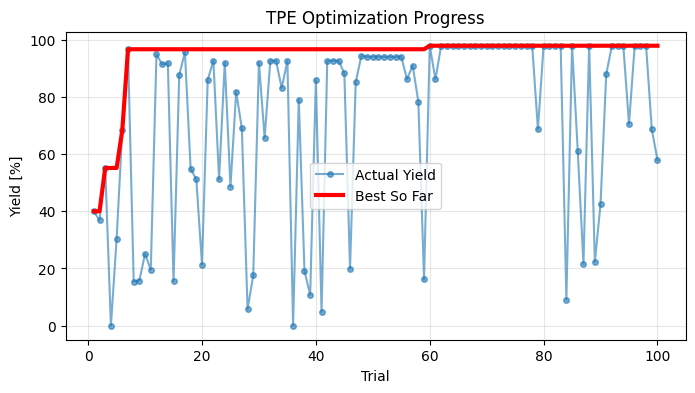

最適化履歴を ../runs/optuna_tpe_100trials_SM/visualization/optimization_progress.png に保存しました


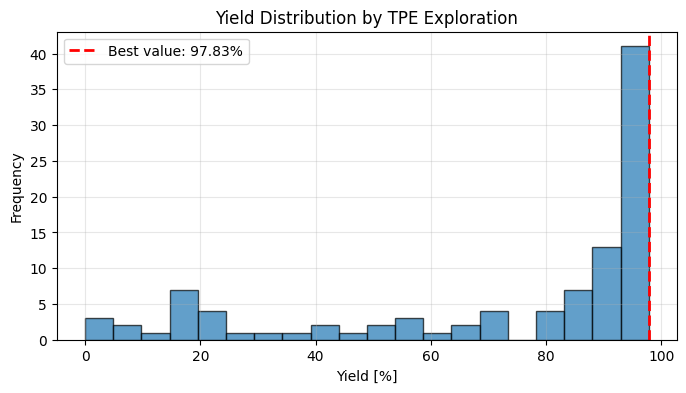

収率分布を ../runs/optuna_tpe_100trials_SM/visualization/yield_distribution.png に保存しました


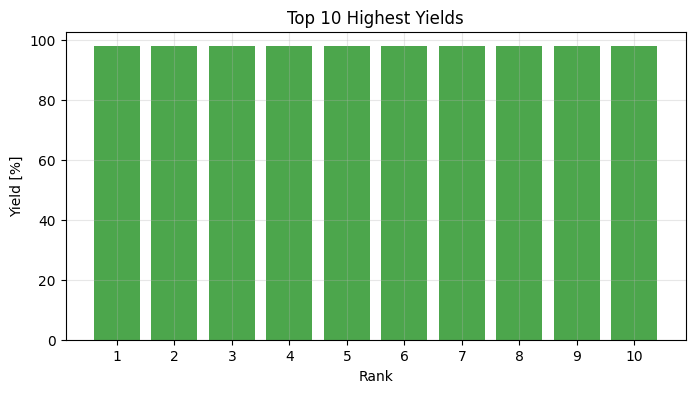

Top 10収率を ../runs/optuna_tpe_100trials_SM/visualization/top10_yields.png に保存しました


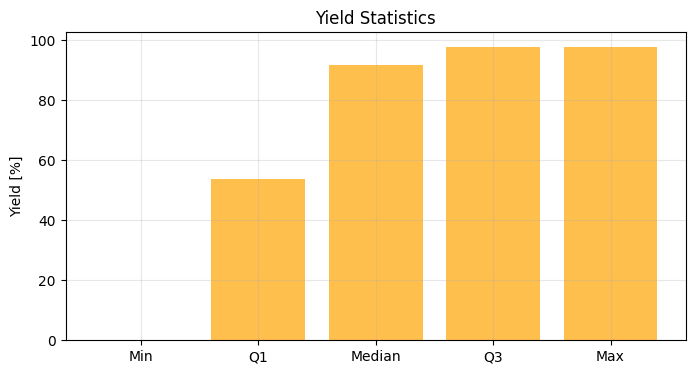

収率統計を ../runs/optuna_tpe_100trials_SM/visualization/yield_statistics.png に保存しました


In [9]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('TPE Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by TPE Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")

## GPSampler

In [10]:
def run_gp_optimization(
    n_trials: int = 100,
    seed: int = 42,
    db_path: str = "../runs/optuna_gp_100trials_SM/optuna_gp_100trials_SM.db",
    *,
    n_startup_trials: int = 10,
    deterministic_objective: bool = False,
):
    """
    反応収率最大化のためのGaussian Process( GP )最適化を実行（Optuna GPSampler）

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス
        n_startup_trials (int): 初期のランダム探索回数（既知データが少ない序盤を安定化）
        deterministic_objective (bool): 目的関数が決定的なら True（ノイズを想定しない学習）

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)

    # GPサンプラーを設定
    sampler = GPSampler(
        seed=seed,
        n_startup_trials=n_startup_trials,
        deterministic_objective=deterministic_objective,
    )

    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction="maximize",                     # 収率を最大化
        sampler=sampler,                          # GPサンプラーを使用
        study_name="gp_yield_optimization_SM",
        storage=f"sqlite:///{db_path}",           # 永続化ストレージ
        load_if_exists=True,                      # 既存DBがあれば再利用
    )

    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study


In [11]:
 study = run_gp_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:20:17,003] A new study created in RDB with name: gp_yield_optimization_SM
Best trial: 0. Best value: 39.9838:   1%|          | 1/100 [00:00<00:23,  4.22it/s]

[I 2025-09-25 06:20:17,233] Trial 0 finished with value: 39.9838434308955 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 0 with value: 39.9838434308955.


Best trial: 0. Best value: 39.9838:   2%|▏         | 2/100 [00:00<00:21,  4.49it/s]

[I 2025-09-25 06:20:17,443] Trial 1 finished with value: 36.7830173819224 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'THF'}. Best is trial 0 with value: 39.9838434308955.


Best trial: 2. Best value: 55.1293:   3%|▎         | 3/100 [00:00<00:23,  4.21it/s]

[I 2025-09-25 06:20:17,698] Trial 2 finished with value: 55.1292974217532 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 2 with value: 55.1292974217532.


[I 2025-09-25 06:20:18,049] Trial 3 finished with value: 0.0 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 2 with value: 55.1292974217532.
[I 2025-09-25 06:20:18,249] Trial 4 finished with value: 30.2905859938007 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(o-Tol)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'THF'}. Best is trial 2 with value: 55.1292974217532.


Best trial: 5. Best value: 68.3272:   6%|▌         | 6/100 [00:01<00:21,  4.35it/s]

[I 2025-09-25 06:20:18,437] Trial 5 finished with value: 68.3271978265171 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 5 with value: 68.3271978265171.


Best trial: 6. Best value: 96.6033:   7%|▋         | 7/100 [00:01<00:21,  4.32it/s]

[I 2025-09-25 06:20:18,645] Trial 6 finished with value: 96.6033244317233 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.
[I 2025-09-25 06:20:18,851] Trial 7 finished with value: 15.410461843799 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:   9%|▉         | 9/100 [00:02<00:18,  4.84it/s]

[I 2025-09-25 06:20:19,039] Trial 8 finished with value: 15.7975197629559 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeCN'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 6. Best value: 96.6033:  10%|█         | 10/100 [00:02<00:20,  4.42it/s]

[I 2025-09-25 06:20:19,310] Trial 9 finished with value: 25.151362606933 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 6 with value: 96.6033244317233.


Best trial: 10. Best value: 96.7008:  11%|█         | 11/100 [00:04<01:05,  1.36it/s]

[I 2025-09-25 06:20:21,190] Trial 10 finished with value: 96.700831389957 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 10 with value: 96.700831389957.


Best trial: 10. Best value: 96.7008:  12%|█▏        | 12/100 [00:04<01:04,  1.36it/s]

[I 2025-09-25 06:20:21,909] Trial 11 finished with value: 66.316553568736 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 10 with value: 96.700831389957.


Best trial: 10. Best value: 96.7008:  13%|█▎        | 13/100 [00:05<00:54,  1.59it/s]

[I 2025-09-25 06:20:22,312] Trial 12 finished with value: 96.3242391228999 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 10 with value: 96.700831389957.


Best trial: 10. Best value: 96.7008:  14%|█▍        | 14/100 [00:05<00:44,  1.93it/s]

[I 2025-09-25 06:20:22,576] Trial 13 finished with value: 93.9385774065647 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 10 with value: 96.700831389957.


Best trial: 10. Best value: 96.7008:  15%|█▌        | 15/100 [00:05<00:37,  2.27it/s]

[I 2025-09-25 06:20:22,821] Trial 14 finished with value: 94.1499649419957 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 10 with value: 96.700831389957.


Best trial: 15. Best value: 98.5294:  16%|█▌        | 16/100 [00:06<00:46,  1.80it/s]

[I 2025-09-25 06:20:23,662] Trial 15 finished with value: 98.5294270039544 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  17%|█▋        | 17/100 [00:07<00:56,  1.47it/s]

[I 2025-09-25 06:20:24,630] Trial 16 finished with value: 83.6605274417068 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  18%|█▊        | 18/100 [00:07<00:45,  1.81it/s]

[I 2025-09-25 06:20:24,887] Trial 17 finished with value: 96.4859324691571 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  19%|█▉        | 19/100 [00:08<00:37,  2.19it/s]

[I 2025-09-25 06:20:25,121] Trial 18 finished with value: 87.3063254584504 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  20%|██        | 20/100 [00:08<00:31,  2.56it/s]

[I 2025-09-25 06:20:25,360] Trial 19 finished with value: 97.4549141405387 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  21%|██        | 21/100 [00:08<00:26,  2.94it/s]

[I 2025-09-25 06:20:25,580] Trial 20 finished with value: 91.3384780171531 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  22%|██▏       | 22/100 [00:08<00:24,  3.13it/s]

[I 2025-09-25 06:20:25,855] Trial 21 finished with value: 90.8868932305634 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  23%|██▎       | 23/100 [00:09<00:23,  3.33it/s]

[I 2025-09-25 06:20:26,102] Trial 22 finished with value: 15.3450097553135 and parameters: {'reactant_1_name': '6-chloroquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  24%|██▍       | 24/100 [00:09<00:22,  3.40it/s]

[I 2025-09-25 06:20:26,387] Trial 23 finished with value: 95.9307105913055 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:26,586] Trial 24 finished with value: 37.2267218939317 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  26%|██▌       | 26/100 [00:09<00:18,  4.02it/s]

[I 2025-09-25 06:20:26,797] Trial 25 finished with value: 92.6045511468057 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:26,995] Trial 26 finished with value: 94.2640845367367 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  29%|██▉       | 29/100 [00:10<00:15,  4.73it/s]

[I 2025-09-25 06:20:27,198] Trial 27 finished with value: 72.9780451596398 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:27,379] Trial 28 finished with value: 78.306905317854 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  30%|███       | 30/100 [00:10<00:14,  4.84it/s]

[I 2025-09-25 06:20:27,575] Trial 29 finished with value: 66.8574734170733 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  31%|███       | 31/100 [00:10<00:14,  4.77it/s]

[I 2025-09-25 06:20:27,787] Trial 30 finished with value: 87.2486387938509 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  33%|███▎      | 33/100 [00:11<00:13,  4.93it/s]

[I 2025-09-25 06:20:27,996] Trial 31 finished with value: 97.4247377479216 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:28,187] Trial 32 finished with value: 13.445608059374 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2c, Trifluoroborate', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  35%|███▌      | 35/100 [00:11<00:14,  4.47it/s]

[I 2025-09-25 06:20:28,510] Trial 33 finished with value: 91.1760889441438 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:28,699] Trial 34 finished with value: 93.6487172275639 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  36%|███▌      | 36/100 [00:11<00:14,  4.51it/s]

[I 2025-09-25 06:20:28,915] Trial 35 finished with value: 94.032958135965 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  37%|███▋      | 37/100 [00:12<00:13,  4.64it/s]

[I 2025-09-25 06:20:29,116] Trial 36 finished with value: 94.0778315683606 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  38%|███▊      | 38/100 [00:12<00:13,  4.68it/s]

[I 2025-09-25 06:20:29,326] Trial 37 finished with value: 91.6885429745619 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:29,520] Trial 38 finished with value: 92.8242218597128 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  40%|████      | 40/100 [00:12<00:12,  4.85it/s]

[I 2025-09-25 06:20:29,721] Trial 39 finished with value: 86.8849327266406 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:29,919] Trial 40 finished with value: 88.6029509376872 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  42%|████▏     | 42/100 [00:13<00:11,  4.97it/s]

[I 2025-09-25 06:20:30,115] Trial 41 finished with value: 76.2519576908742 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dtbpf', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:30,310] Trial 42 finished with value: 96.1446416304454 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  44%|████▍     | 44/100 [00:13<00:11,  4.96it/s]

[I 2025-09-25 06:20:30,517] Trial 43 finished with value: 93.1337812573883 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:30,712] Trial 44 finished with value: 93.119800141071 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  47%|████▋     | 47/100 [00:14<00:10,  5.07it/s]

[I 2025-09-25 06:20:30,916] Trial 45 finished with value: 88.5035713430579 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:31,105] Trial 46 finished with value: 88.5732832728593 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  48%|████▊     | 48/100 [00:14<00:10,  5.01it/s]

[I 2025-09-25 06:20:31,310] Trial 47 finished with value: 83.9317779392095 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'XPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  49%|████▉     | 49/100 [00:14<00:12,  4.06it/s]

[I 2025-09-25 06:20:31,666] Trial 48 finished with value: 61.5278331829394 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'Xantphos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  50%|█████     | 50/100 [00:14<00:11,  4.25it/s]

[I 2025-09-25 06:20:31,874] Trial 49 finished with value: 90.2136774697692 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  51%|█████     | 51/100 [00:15<00:12,  4.07it/s]

[I 2025-09-25 06:20:32,145] Trial 50 finished with value: 87.8391577701505 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:32,344] Trial 51 finished with value: 90.9965779946587 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  53%|█████▎    | 53/100 [00:15<00:10,  4.31it/s]

[I 2025-09-25 06:20:32,574] Trial 52 finished with value: 63.2047946537133 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  54%|█████▍    | 54/100 [00:15<00:10,  4.35it/s]

[I 2025-09-25 06:20:32,800] Trial 53 finished with value: 95.6509037806468 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:32,994] Trial 54 finished with value: 92.0669339153271 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  56%|█████▌    | 56/100 [00:16<00:09,  4.70it/s]

[I 2025-09-25 06:20:33,193] Trial 55 finished with value: 91.353764505891 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  57%|█████▋    | 57/100 [00:16<00:09,  4.59it/s]

[I 2025-09-25 06:20:33,420] Trial 56 finished with value: 94.1467620779593 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  58%|█████▊    | 58/100 [00:16<00:08,  4.70it/s]

[I 2025-09-25 06:20:33,624] Trial 57 finished with value: 93.8157601820839 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  59%|█████▉    | 59/100 [00:16<00:08,  4.64it/s]

[I 2025-09-25 06:20:33,843] Trial 58 finished with value: 96.489796574186 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


[I 2025-09-25 06:20:34,075] Trial 59 finished with value: 90.0727586381624 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  61%|██████    | 61/100 [00:17<00:08,  4.67it/s]

[I 2025-09-25 06:20:34,277] Trial 60 finished with value: 92.516503860365 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  62%|██████▏   | 62/100 [00:17<00:08,  4.68it/s]

[I 2025-09-25 06:20:34,488] Trial 61 finished with value: 92.5414293181436 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  63%|██████▎   | 63/100 [00:17<00:07,  4.72it/s]

[I 2025-09-25 06:20:34,697] Trial 62 finished with value: 95.9532385279647 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  64%|██████▍   | 64/100 [00:18<00:07,  4.58it/s]

[I 2025-09-25 06:20:34,929] Trial 63 finished with value: 89.7383680766021 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.
[I 2025-09-25 06:20:35,128] Trial 64 finished with value: 93.27071104035 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  66%|██████▌   | 66/100 [00:18<00:07,  4.76it/s]

[I 2025-09-25 06:20:35,334] Trial 65 finished with value: 87.6806814105779 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeCN'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  67%|██████▋   | 67/100 [00:18<00:11,  2.94it/s]

[I 2025-09-25 06:20:35,976] Trial 66 finished with value: 95.306313127429 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  68%|██████▊   | 68/100 [00:19<00:10,  2.92it/s]

[I 2025-09-25 06:20:36,320] Trial 67 finished with value: 84.7999059097482 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 15. Best value: 98.5294:  69%|██████▉   | 69/100 [00:19<00:09,  3.11it/s]

[I 2025-09-25 06:20:36,595] Trial 68 finished with value: 88.5877021457918 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'NaHCO3', 'solvent_1_short_hand': 'MeOH'}. Best is trial 15 with value: 98.5294270039544.


Best trial: 69. Best value: 98.6922:  70%|███████   | 70/100 [00:19<00:09,  3.08it/s]

[I 2025-09-25 06:20:36,929] Trial 69 finished with value: 98.6922177153939 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  71%|███████   | 71/100 [00:20<00:10,  2.77it/s]

[I 2025-09-25 06:20:37,375] Trial 70 finished with value: 98.2020524115041 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  72%|███████▏  | 72/100 [00:20<00:08,  3.17it/s]

[I 2025-09-25 06:20:37,584] Trial 71 finished with value: 92.968105197347 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  73%|███████▎  | 73/100 [00:20<00:07,  3.45it/s]

[I 2025-09-25 06:20:37,813] Trial 72 finished with value: 93.2824954358793 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  74%|███████▍  | 74/100 [00:21<00:06,  3.78it/s]

[I 2025-09-25 06:20:38,020] Trial 73 finished with value: 89.2862717770382 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  75%|███████▌  | 75/100 [00:21<00:06,  3.90it/s]

[I 2025-09-25 06:20:38,254] Trial 74 finished with value: 91.4651756598927 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'CataCXium A', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  76%|███████▌  | 76/100 [00:21<00:07,  3.22it/s]

[I 2025-09-25 06:20:38,692] Trial 75 finished with value: 94.8302362359257 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  77%|███████▋  | 77/100 [00:22<00:08,  2.62it/s]

[I 2025-09-25 06:20:39,237] Trial 76 finished with value: 91.170968729632 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'THF'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  78%|███████▊  | 78/100 [00:22<00:08,  2.48it/s]

[I 2025-09-25 06:20:39,694] Trial 77 finished with value: 84.380228086177 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 69. Best value: 98.6922:  79%|███████▉  | 79/100 [00:22<00:07,  2.77it/s]

[I 2025-09-25 06:20:39,955] Trial 78 finished with value: 90.3641871583172 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 69 with value: 98.6922177153939.


Best trial: 79. Best value: 99.1471:  80%|████████  | 80/100 [00:23<00:06,  3.14it/s]

[I 2025-09-25 06:20:40,175] Trial 79 finished with value: 99.147081696691 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  81%|████████  | 81/100 [00:23<00:06,  3.14it/s]

[I 2025-09-25 06:20:40,493] Trial 80 finished with value: 94.6976018111647 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  82%|████████▏ | 82/100 [00:23<00:05,  3.37it/s]

[I 2025-09-25 06:20:40,738] Trial 81 finished with value: 99.0461739945196 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  83%|████████▎ | 83/100 [00:24<00:05,  3.24it/s]

[I 2025-09-25 06:20:41,075] Trial 82 finished with value: 97.9833024580542 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  84%|████████▍ | 84/100 [00:24<00:07,  2.22it/s]

[I 2025-09-25 06:20:41,860] Trial 83 finished with value: 91.1772977676256 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'CsF', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  85%|████████▌ | 85/100 [00:25<00:05,  2.60it/s]

[I 2025-09-25 06:20:42,087] Trial 84 finished with value: 96.2821728647772 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'DMF'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  86%|████████▌ | 86/100 [00:25<00:05,  2.67it/s]

[I 2025-09-25 06:20:42,439] Trial 85 finished with value: 93.4379969374087 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  87%|████████▋ | 87/100 [00:25<00:04,  3.08it/s]

[I 2025-09-25 06:20:42,648] Trial 86 finished with value: 51.045416899753 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'dppf', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  88%|████████▊ | 88/100 [00:25<00:03,  3.19it/s]

[I 2025-09-25 06:20:42,934] Trial 87 finished with value: 87.8139516657921 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  89%|████████▉ | 89/100 [00:26<00:03,  3.50it/s]

[I 2025-09-25 06:20:43,155] Trial 88 finished with value: 87.5698654957988 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Cy)3', 'reagent_1_short_hand': 'NaOH', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  90%|█████████ | 90/100 [00:26<00:02,  3.75it/s]

[I 2025-09-25 06:20:43,377] Trial 89 finished with value: 85.1387821692071 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'K3PO4', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.
[I 2025-09-25 06:20:43,577] Trial 90 finished with value: 94.7130894737261 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'THF'}. Best is trial 79 with value: 99.147081696691.


[I 2025-09-25 06:20:43,827] Trial 91 finished with value: 85.9243229100607 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(tBu)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  93%|█████████▎| 93/100 [00:27<00:01,  4.27it/s]

[I 2025-09-25 06:20:44,028] Trial 92 finished with value: 99.147081696691 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeCN'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  94%|█████████▍| 94/100 [00:28<00:04,  1.42it/s]

[I 2025-09-25 06:20:45,835] Trial 93 finished with value: 89.8002920661409 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'Et3N', 'solvent_1_short_hand': 'MeOH'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  95%|█████████▌| 95/100 [00:29<00:02,  1.80it/s]

[I 2025-09-25 06:20:46,044] Trial 94 finished with value: 95.4927179445054 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'DMF'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  96%|█████████▌| 96/100 [00:29<00:01,  2.19it/s]

[I 2025-09-25 06:20:46,264] Trial 95 finished with value: 92.3311863723015 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'MeOH'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  97%|█████████▋| 97/100 [00:29<00:01,  1.96it/s]

[I 2025-09-25 06:20:46,904] Trial 96 finished with value: 93.7907153740685 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'SPhos', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'DMF'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  98%|█████████▊| 98/100 [00:30<00:00,  2.36it/s]

[I 2025-09-25 06:20:47,116] Trial 97 finished with value: 87.7846242598397 and parameters: {'reactant_1_name': '6-Bromoquinoline', 'reactant_2_name': '2a, Boronic Acid', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'LiOtBu', 'solvent_1_short_hand': 'THF'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471:  99%|█████████▉| 99/100 [00:30<00:00,  2.76it/s]

[I 2025-09-25 06:20:47,345] Trial 98 finished with value: 94.2023130760561 and parameters: {'reactant_1_name': '6-triflatequinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'P(Ph)3', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'MeOH'}. Best is trial 79 with value: 99.147081696691.


Best trial: 79. Best value: 99.1471: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]

[I 2025-09-25 06:20:47,848] Trial 99 finished with value: 91.3490076349663 and parameters: {'reactant_1_name': '6-Iodoquinoline', 'reactant_2_name': '2b, Boronic Ester', 'catalyst_1_short_hand': 'Pd(OAc)2', 'ligand_short_hand': 'AmPhos', 'reagent_1_short_hand': 'KOH', 'solvent_1_short_hand': 'DMF'}. Best is trial 79 with value: 99.147081696691.
最適化完了
最良の収率: 99.15%
最適な反応条件:
  reactant_1_name: 6-Iodoquinoline
  reactant_2_name: 2b, Boronic Ester
  catalyst_1_short_hand: Pd(OAc)2
  ligand_short_hand: AmPhos
  reagent_1_short_hand: LiOtBu
  solvent_1_short_hand: MeCN
最適化結果の保存先: ../runs/optuna_gp_100trials_SM/optuna_gp_100trials_SM.db


### 可視化

In [12]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_gp_100trials_NiB/optuna_gp_100trials_SM.db"
viz_dir = "../runs/optuna_gp_100trials_SM/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="gp_yield_optimization_SM",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

❌ スタディの読み込み中にエラーが発生しました: 'Record does not exist.'
最適化セクションを先に実行してください！


In [13]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

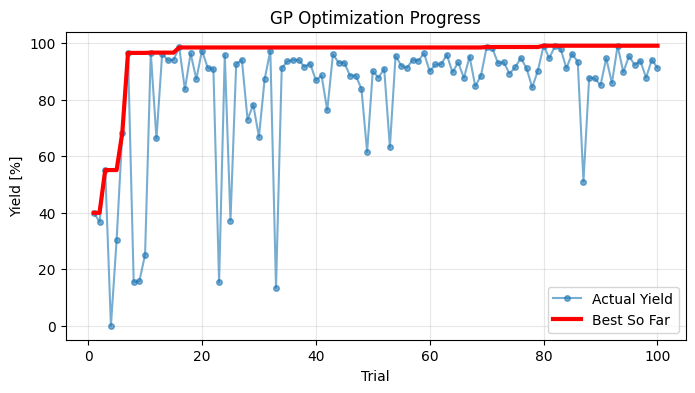

最適化履歴を ../runs/optuna_gp_100trials_SM/visualization/optimization_progress.png に保存しました


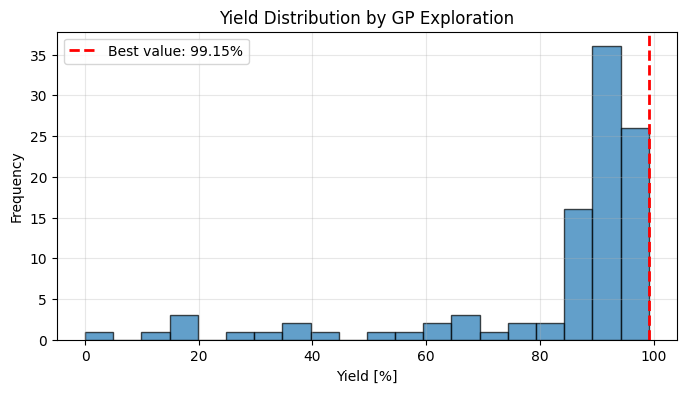

収率分布を ../runs/optuna_gp_100trials_SM/visualization/yield_distribution.png に保存しました


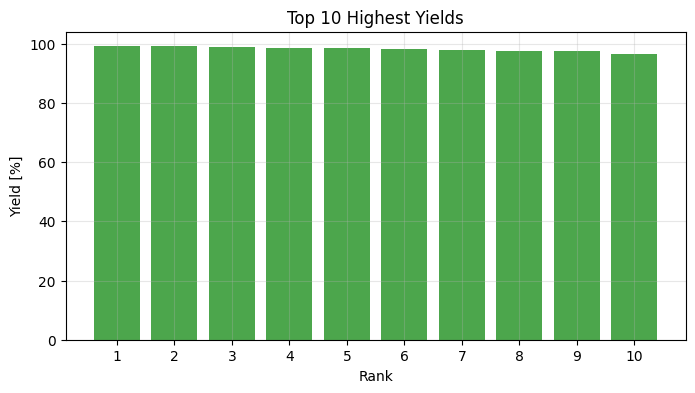

Top 10収率を ../runs/optuna_gp_100trials_SM/visualization/top10_yields.png に保存しました


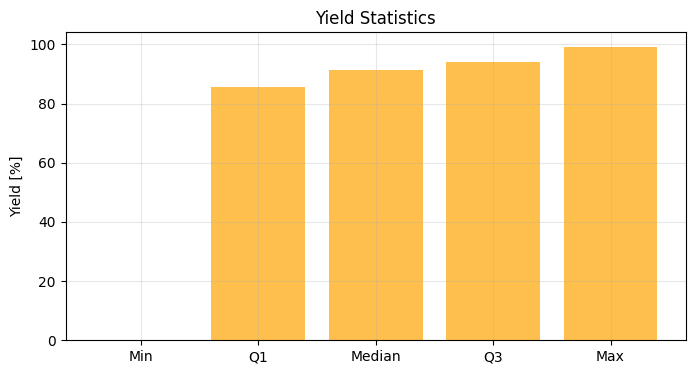

収率統計を ../runs/optuna_gp_100trials_SM/visualization/yield_statistics.png に保存しました


In [14]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('GP Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by GP Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")